In [32]:
import dataset
import tensorflow as tf
import numpy as np
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics as sk_mtr
from model import build_model

In [33]:
texts, sentiments = dataset.load()
test_texts, test_sentiments = dataset.load_test()

In [34]:
texts[0], sentiments[0]

(' I`d have responded, if I were going', 'neutral')

In [35]:
test_texts[0], test_sentiments[0]

('Last session of the day  http://twitpic.com/67ezh', 'neutral')

In [36]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(2000)
tokenizer.fit_on_texts(texts)

vocab_size = tokenizer.num_words

In [37]:
ds_train = dataset.getDataset(tokenizer, batch_size=256)
ds_test = dataset.getDataset(tokenizer, batch_size=256, test=True)

In [59]:
model = build_model(vocab_size)

In [60]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
              
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True, verbose=1)

In [61]:
history = model.fit(ds_train, epochs=50, validation_data=ds_test, callbacks=[mc])
model.save_weights('best_model.h5')

Train for 107 steps, validate for 13 steps
Epoch 1/50
106/107 [============================>.] - ETA: 0s - loss: 1.1350 - accuracy: 0.3980
Epoch 00001: val_loss improved from inf to 1.11803, saving model to best_model.h5
107/107 [==============================] - 4s 39ms/step - loss: 1.1348 - accuracy: 0.3983 - val_loss: 1.1180 - val_accuracy: 0.4047
Epoch 2/50
102/107 [===========================>..] - ETA: 0s - loss: 1.1095 - accuracy: 0.4038
Epoch 00002: val_loss improved from 1.11803 to 1.10066, saving model to best_model.h5
107/107 [==============================] - 1s 10ms/step - loss: 1.1090 - accuracy: 0.4045 - val_loss: 1.1007 - val_accuracy: 0.4066
Epoch 3/50
101/107 [===========================>..] - ETA: 0s - loss: 1.0966 - accuracy: 0.4043
Epoch 00003: val_loss improved from 1.10066 to 1.09090, saving model to best_model.h5
107/107 [==============================] - 1s 10ms/step - loss: 1.0964 - accuracy: 0.4047 - val_loss: 1.0909 - val_accuracy: 0.4066
Epoch 4/50
102/107 

In [62]:
model = build_model(vocab_size)
model.load_weights('best_model.h5')
predictions = model.predict(ds_test)

In [63]:
confusion = np.zeros((3,3))
for batch in ds_test:
    predictions = model.predict(batch[0])
    for true, pred in zip(batch[1], predictions):
        true_label = np.argmax(true)
        pred_label = np.argmax(pred)
        confusion[true_label, pred_label] +=1

print(confusion)

[[557. 322.  49.]
 [143. 995. 201.]
 [ 26. 214. 821.]]


In [64]:
import matplotlib.pyplot as plt

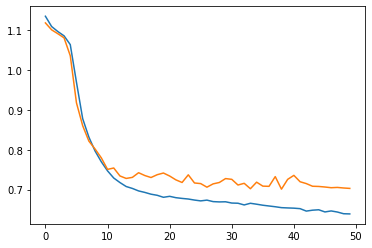

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

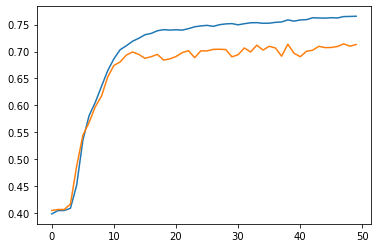

In [66]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']);

In [67]:
model.layers[0].weights

[<tf.Variable 'embedding_9/embeddings:0' shape=(2000, 32) dtype=float32, numpy=
 array([[ 0.04424066, -0.01784859, -0.0432557 , ...,  0.01719034,
          0.00955299, -0.01215024],
        [-0.03365136,  0.01069328,  0.05879226, ..., -0.02574051,
         -0.01190598, -0.00310444],
        [ 0.01170665, -0.00657572, -0.04220049, ..., -0.01669901,
         -0.00840161, -0.00816824],
        ...,
        [-0.00123701, -0.00586937, -0.00472165, ...,  0.00338023,
         -0.00943799, -0.00431655],
        [-0.00681446,  0.00374831, -0.00764997, ..., -0.00799815,
         -0.00547371,  0.00555813],
        [ 0.00618423, -0.00730927, -0.00237894, ...,  0.00973711,
         -0.01399849, -0.00641342]], dtype=float32)>]

In [68]:
sum([1 if sent == 'neutral' else 0 for sent in test_sentiments])

1430

In [69]:
data = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(texts), padding='post')
print(sk_mtr.classification_report(
    y_true=dataset.sentiments_to_number(sentiments),
    y_pred=np.argmax(model.predict(data, batch_size=128),axis=1),
))

precision    recall  f1-score   support

           0       0.80      0.71      0.75      7781
           1       0.72      0.81      0.76     11118
           2       0.85      0.79      0.82      8582

    accuracy                           0.78     27481
   macro avg       0.79      0.77      0.78     27481
weighted avg       0.78      0.78      0.78     27481



In [70]:
data = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(test_texts), padding='post')
print(sk_mtr.classification_report(
    y_true=dataset.sentiments_to_number(test_sentiments),
    y_pred=np.argmax(model.predict(data, batch_size=128),axis=1),
))

precision    recall  f1-score   support

           0       0.77      0.61      0.68      1001
           1       0.65      0.74      0.69      1430
           2       0.76      0.77      0.77      1103

    accuracy                           0.71      3534
   macro avg       0.73      0.71      0.71      3534
weighted avg       0.72      0.71      0.71      3534



In [71]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)